The Ising model is named after Ernst Ising, Ph.D. in Physics (1924) from the University of Hamburg under the supervision of Wilhelm Lenz. Ising solved the one-dimensional (1D) Ising model exactly to find no phase transition. He also provided arguments on why there would not be a phase transition in higher dimensions either. In 1936, Peierls argued that both 2D and 3D Ising models admit phase transitions.



In [27]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye

In [28]:
#---------------------------PARAMETERS------------------------------------
nt      = 10         #  Number of temperature points
N       = 30         #  Size of the lattice, N x N
B       = 0.05       #  Outside Field
Tstart  = 1.5        #  T1
Tend    = 4          #  T2
eqSteps = 200        #  number of MC sweeps for equilibration
mcSteps = 2000       #  number of MC sweeps for calculation

#---------------------------VARIABLES-------------------------------------
T       = np.linspace(Tstart, Tend, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values 

In [29]:
#---------------------------Initial Grid------------------------------------
def initialstate(N):   
    ''' 
    Generates a random spin configuration for initial condition
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

In [30]:
#---------------------------MC Steps------------------------------------
def mcmove(config, beta):
    '''
    Monte Carlo move using Metropolis algorithm 
    '''
    
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb+2*B*s
                
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config

In [31]:
#---------------------------Calculators------------------------------------
def calcEnergy(config):
    '''
    Energy of a given configuration
    '''
    energy = 0 
    
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            h = -nb*S-B*nb
            energy += h
    return energy/2.  # to compensate for over-counting



def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(config)
    return mag

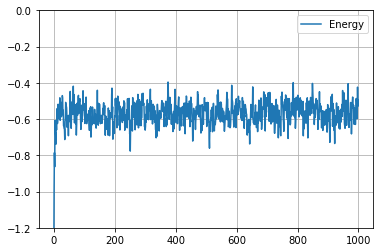

In [32]:
#---------------------------Eq test------------------------------------
config = np.ones((N,N)) 
Ene = []
Ttest = 4

for i in range(1000):                            
                mcmove(config, 1/Ttest)       # Monte Carlo moves
                Ene.append(calcEnergy(config)/N/N)
                

fig, ax = plt.subplots(1, 1)
ax.plot(Ene, label="Energy")
ax.set_ylim(-1.2,0)
plt.grid()
plt.legend()


In [33]:
#--------------------------------Simulation--------------------------------------
for tt in range(nt):
    config = initialstate(N)         # initialise

    E1 = M1 = E2 = M2 = 0
    iT=1.0/T[tt]; iT2=iT*iT
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene


    # divide by number of sites and iteractions to obtain intensive values    
    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

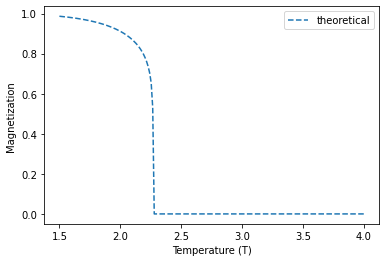

In [34]:
#--------------------------------Onsager Solution--------------------------------------
Onsager_Tc = 2.269
Ts_plot = np.linspace(Tstart, Tend, num=200)
Onsager_Ms = np.zeros(len(Ts_plot))
for i, T1 in enumerate(Ts_plot):
    if T1 <= 2.269:
        Onsager_Ms[i] = (1 - (np.sinh(2/T1))**(-4))**(1/8)
plt.plot(Ts_plot, Onsager_Ms, '--', label='theoretical')
plt.xlabel("Temperature (T)", fontsize=10); 
plt.ylabel("Magnetization ", fontsize=10);   plt.axis('tight')
plt.legend()
plt.show()



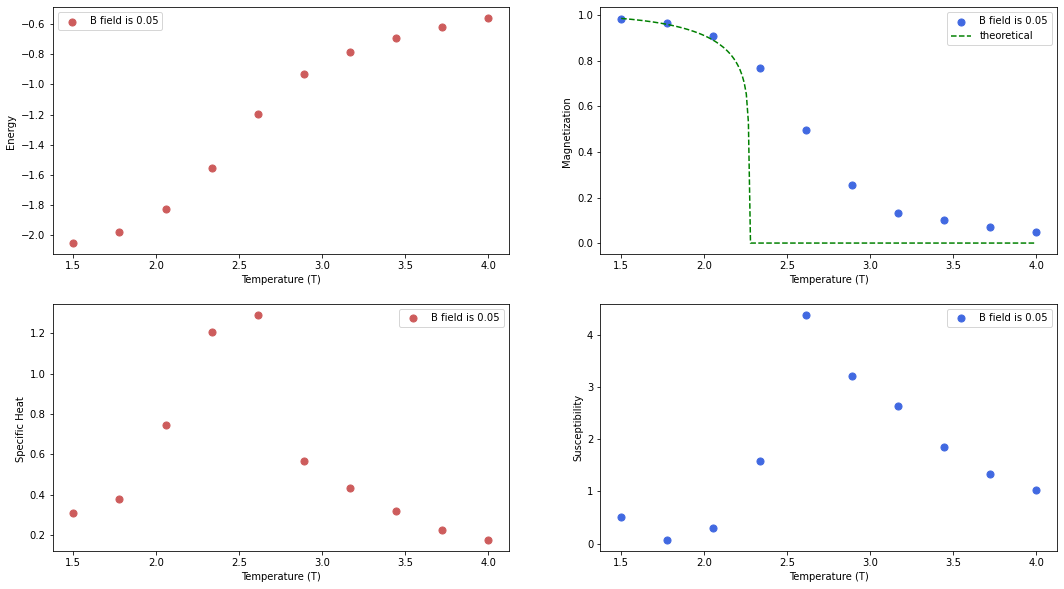

In [35]:
#--------------------------------Plotting--------------------------------------
f = plt.figure(figsize=(18, 10)); 

sp =  f.add_subplot(2, 2, 1 )
plt.scatter(T, E, s=50, marker='o', color='IndianRed',label='B field is {}'.format(B))
plt.xlabel("Temperature (T)", fontsize=10)
plt.ylabel("Energy ", fontsize=10);         plt.axis('tight')
plt.legend()

sp =  f.add_subplot(2, 2, 2 )
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue',label='B field is {}'.format(B))
plt.plot(Ts_plot, Onsager_Ms, '--', color='Green',label='theoretical')
plt.xlabel("Temperature (T)", fontsize=10); 
plt.ylabel("Magnetization ", fontsize=10);   plt.axis('tight')
plt.legend()

sp =  f.add_subplot(2, 2, 3 )
plt.scatter(T, C, s=50, marker='o', color='IndianRed',label='B field is {}'.format(B))
plt.xlabel("Temperature (T)", fontsize=10);  
plt.ylabel("Specific Heat ", fontsize=10);   plt.axis('tight');   
plt.legend()

sp =  f.add_subplot(2, 2, 4 )
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue',label='B field is {}'.format(B))
plt.xlabel("Temperature (T)", fontsize=10); 
plt.ylabel("Susceptibility", fontsize=10);   plt.axis('tight')
plt.legend()

plt.show()

In [36]:
%matplotlib inline
# Simulating the Ising model


class Ising():
    ''' Simulating the Ising model '''    
    
    
    ## monte carlo moves
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    

    
    def simulate(self):   
        ''' This module simulates the Ising model'''
        N, temp     = 64, 0.5        # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1
        f = plt.figure(figsize=(15, 15), dpi=80);    
        self.configPlot(f, config, 0, N, 1);
        
        msrmnt = 1001
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0/temp)
            if i == 1:       self.configPlot(f, config, i, N, 2);
            if i == 4:       self.configPlot(f, config, i, N, 3);
            if i == 32:      self.configPlot(f, config, i, N, 4);
            if i == 100:     self.configPlot(f, config, i, N, 5);
            if i == 1000:    self.configPlot(f, config, i, N, 6);
                 
                    
    def configPlot(self, f, config, i, N, n_):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.tab20)
        plt.title('Time=%d'%i); plt.axis('tight')    

    plt.show()

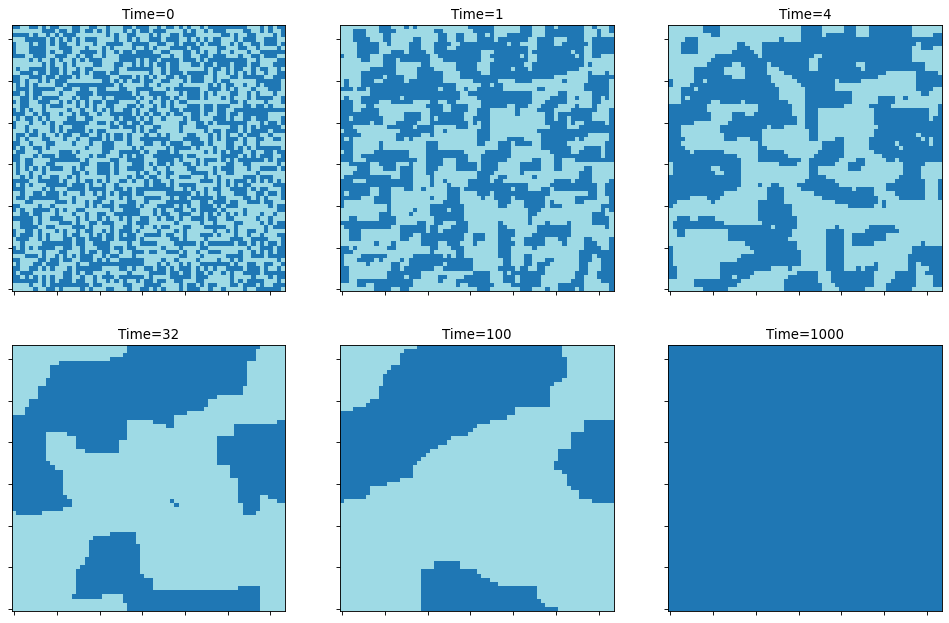

In [37]:
rm = Ising()
rm.simulate()

In [38]:
# This example uses the 5-point Laplacian discretization from 


%matplotlib inline


a,b, k = 0, 1.0, 100.0
dh, dt = 1.0, 1e-3
Ng, Tf = 64, 5001




class TDGL():
    '''
    Class to solve a PDE 
    '''
    
    def mu(self, u):
        return a*u + b*u*u*u 

    
    
    def laplacian(self, Ng):
        '''Construct a sparse matrix that applies the 5-point Laplacian discretization'''
        e=np.ones(Ng**2)
        e2=([1]*(Ng-1)+[0])*Ng
        e3=([0]+[1]*(Ng-1))*Ng
        h=dh
        A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-Ng,Ng],Ng**2,Ng**2)
        A/=h**2
        return A

    
    
    def integrate(self, L, x, y, u):
        '''  simulates the equation and plots it at different instants '''
        
        f = plt.figure(figsize=(15, 15), dpi=80);    

        for i in range(Tf):          
            u = u - dt*(self.mu(u) - k*L.dot(u))
            
            if (i==0):      self.configPlot(x, y, u, f, 1, i);
            if (i==1):      self.configPlot(x, y, u, f, 2, i);
            if (i==10):     self.configPlot(x, y, u, f, 3, i);
            if (i==100):    self.configPlot(x, y, u, f, 4, i);
            if (i==500):   self.configPlot(x, y, u, f, 5, i);
            if (i==1000):  self.configPlot(x, y, u, f, 6, i);
   


    def configPlot(self, x, y, u,f, n_, i):
        U= u.reshape((Ng, Ng))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)
        plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i)
    plt.show()

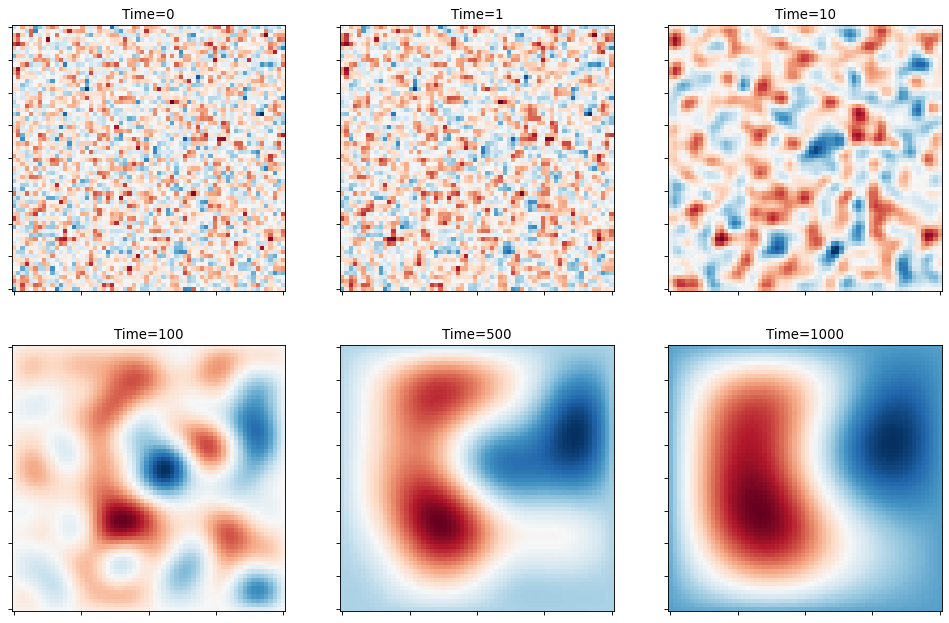

In [39]:
rm = TDGL()   # instantiate the class

# generate the grid and initialise the field
x = np.linspace(-1,1,Ng)
y = np.linspace(-1,1,Ng)
X, Y = np.meshgrid(x, y)

u=np.random.randn(Ng*Ng, 1);  # Initial data
L = rm.laplacian(Ng)        
rm.integrate(L, x, y, u)    # simulate